In [2]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss
from utils.uniform_models import ZeroOutput

from toy_models.parallel_serial_network import CustomMLP
from torch import Tensor



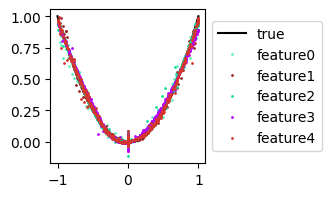

In [3]:
# Load model and data
model_path = "../outputs/toy_models/squared.pt"
model = torch.load(model_path)['model']
n_features = model.layers[0].in_features

X, _ = GenerateTMSData(num_features=n_features, num_datapoints=10000, sparsity=.05, batch_size=32)
X = X * (2*torch.rand_like(X).round() - 1)
#X = X[(X!=0).sum(dim=-1)==1,:]
Y = X**2
Y_pred = model(X)

plt.figure(figsize=(2,2))
np.random.seed(42)

X_true = np.linspace(-1,1,1000)
Y_true = X_true**2
plt.plot(X_true, Y_true, 'k-', label='true')


for i in range(X.shape[1]):
    # Pick a random color
    color = np.random.rand(3,)
    plt.plot(X[:, i].cpu().detach().numpy(), Y_pred[:,i].cpu().detach().numpy(), '.', markersize=2, color=color, label=f"feature{i}")
    
# Put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    

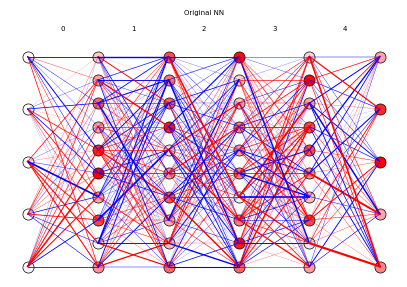

In [4]:
model_params = dict(model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

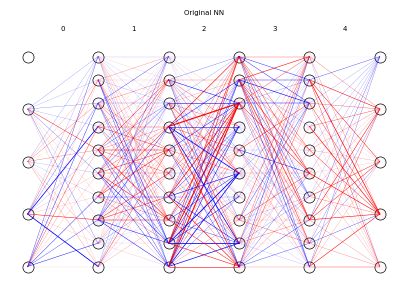

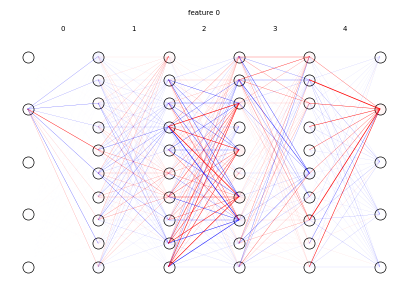

<Figure size 200x200 with 0 Axes>

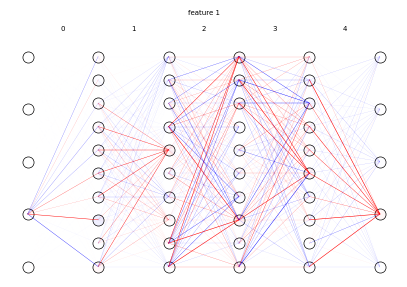

<Figure size 200x200 with 0 Axes>

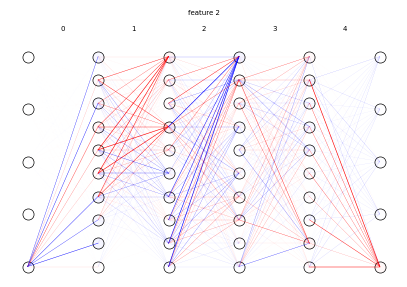

<Figure size 200x200 with 0 Axes>

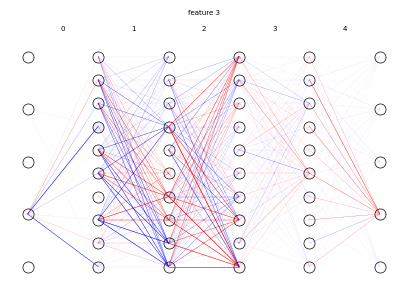

<Figure size 200x200 with 0 Axes>

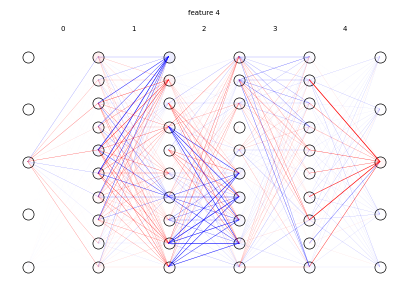

<Figure size 200x200 with 0 Axes>

In [5]:
eigenmodel_path = "../outputs/eigenmodels/squared.pt"

checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:10*v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

#X = 2*torch.rand(10000,1).to('cuda')-1
#feature_vals = eigenmodel(eigenmodel.compute_jacobian(X))


for i, network in enumerate(eigenmodel.construct_subnetworks()):
    
    weights = {k:v for k,v in network.items() if 'bias' not in k}
    weights = {str(i):10*v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'bias' in k}
    biases = {str(i):v for i,v in enumerate(biases.values())}

    f = DrawNeuralNetwork(weights, biases, f"feature {i}")

    plt.figure(figsize=(2,2))
    #plt.plot(X.detach().cpu().numpy(), feature_vals[:,i].detach().cpu().numpy(), '.', markersize=1)
    #plt.xlabel('input value')
    #plt.ylabel('dL dF')
    #plt.title(f'Feature {i}')
    plt.show()

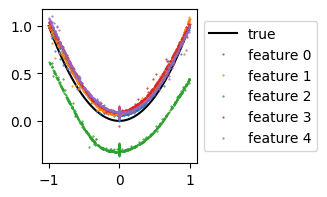

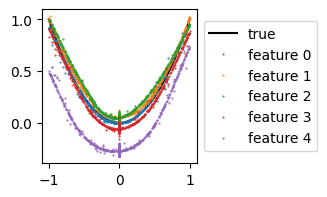

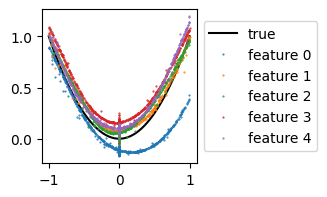

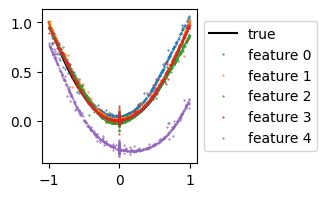

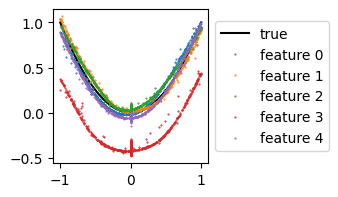

In [6]:
feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
toy_model = copy.deepcopy(eigenmodel.model)
orig_y = toy_model(X)
for feature_idx in range(5):
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    feature_coefficients[feature_idx] = -.2
    reconstruction = eigenmodel.add_to_network(feature_coefficients)
    # Repalce toy model parameters with model_params
    toy_model.load_state_dict(reconstruction)
    y = (toy_model(X) ).cpu().detach().numpy()
    plt.figure(figsize=(2,2))
    plt.plot(np.linspace(-1,1,100), np.linspace(-1,1,100)**2, 'k-', label='true')
    for i in range(y.shape[1]):
        plt.plot(X[:,-i].cpu().detach().numpy(), y[:,-i], '.', label=f"feature {i}",  markersize=1) #, bins=np.linspace(-.1,.1,100), alpha=.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




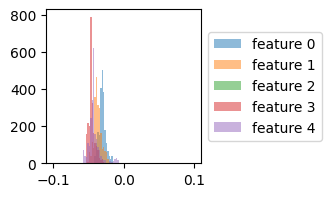

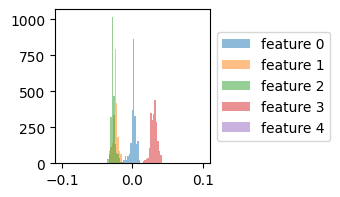

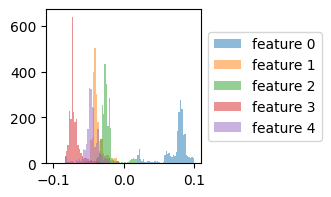

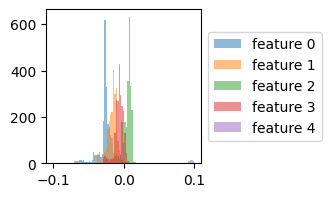

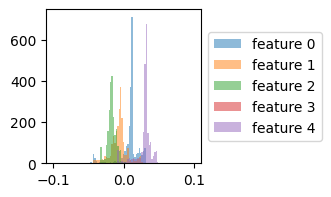

In [7]:
feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
toy_model = copy.deepcopy(eigenmodel.model)
orig_y = toy_model(X)
for feature_idx in range(5):
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    feature_coefficients[feature_idx] = .1
    reconstruction = eigenmodel.add_to_network(feature_coefficients)
    # Repalce toy model parameters with model_params
    toy_model.load_state_dict(reconstruction)
    y = (toy_model(X) - orig_y).cpu().detach().numpy()
    plt.figure(figsize=(2,2))
    for i in range(y.shape[1]):
        plt.hist(y[:,-i], label=f"feature {i}", bins=np.linspace(-.1,.1,100), alpha=.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




In [8]:
eigenmodel.low_rank_decode['0.weight'][0]

tensor([[[ 0.0143, -0.0407,  0.0079, -0.0540, -0.0263],
         [-0.0143, -0.0407, -0.0079, -0.0540, -0.0263],
         [ 0.0143, -0.0407,  0.0079, -0.0540,  0.0263],
         [-0.0143,  0.0407,  0.0079, -0.0540,  0.0263],
         [-0.0143,  0.0407, -0.0079, -0.0540,  0.0263],
         [ 0.0143,  0.0407,  0.0079, -0.0540,  0.0263],
         [-0.0143, -0.0407,  0.0079,  0.0540, -0.0263],
         [ 0.0143,  0.0407, -0.0079, -0.0540, -0.0263],
         [-0.0143,  0.0407,  0.0079,  0.0540, -0.0263],
         [ 0.0143,  0.0407, -0.0079,  0.0540, -0.0263]],

        [[-0.0262, -0.0015, -0.0526,  0.0118, -0.0208],
         [ 0.0262, -0.0015,  0.0526,  0.0118, -0.0208],
         [-0.0262, -0.0015, -0.0526,  0.0118,  0.0208],
         [ 0.0262,  0.0015, -0.0526,  0.0118,  0.0208],
         [ 0.0262,  0.0015,  0.0526,  0.0118,  0.0208],
         [-0.0262,  0.0015, -0.0526,  0.0118,  0.0208],
         [ 0.0262, -0.0015, -0.0526, -0.0118, -0.0208],
         [-0.0262,  0.0015,  0.0526,  0.0118, 

In [9]:
eigenmodel.low_rank
for i, (name, tensors) in enumerate(eigenmodel.low_rank.items()):
    if i ==0:
        sum_squares = sum([(t**2).sum(dim=list(range(len(t.shape)-1))) for t in tensors])
    else:
        sum_squares = sum_squares + sum([(t**2).sum(dim=list(range(len(t.shape)-1))) for t in tensors])

for i, (name, tensors) in enumerate(eigenmodel.low_rank.items()):
    for t in tensors:
        # Divide t by a value and keep the gradient stored
        t.data.div_(sum_squares+100)

AttributeError: 'EigenModel' object has no attribute 'low_rank'

In [ ]:
t.

tensor([[[-6.2870,  1.4383, -0.6988,  1.7164, -0.5703,  1.2102,  7.3328,
          -2.8243,  0.1245, -6.8140]]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [ ]:
sum([(t**2).sum(dim=list(range(len(t.shape)-1))) for t in tensors])

tensor([3.4093e-08, 7.8468e-06, 1.7339e-02, 4.9321e-07, 2.0704e-02, 1.5193e-04,
        2.7574e-05, 4.2468e-06, 1.8260e-08, 6.2213e-07], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
tensors[1].sum(dim=list(range(1, len(tensors[1].shape))))

tensor([-0.0081], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
tensors

[tensor([[[ 4.6926e-05,  7.2303e-04, -2.7523e-02,  5.7814e-04,  5.1092e-02,
           -3.4846e-03, -2.0545e-03, -1.1891e-03,  5.5783e-05, -1.8134e-04]],
 
         [[-1.6750e-04,  2.4002e-03,  1.2777e-01,  2.5716e-04,  1.1244e-01,
            1.1715e-02, -4.2159e-03, -1.4051e-03,  6.9591e-05, -4.2745e-04]],
 
         [[ 6.1898e-05,  1.2355e-03,  1.2001e-02,  2.2204e-04,  7.3797e-02,
           -9.9725e-04, -2.3557e-03,  7.4805e-05,  1.0148e-04,  5.1657e-04]]],
        device='cuda:0', requires_grad=True),
 tensor([[[-2.2589e-06,  1.9222e-04, -1.0613e-02,  2.0865e-04,  1.8982e-03,
           -1.2429e-03,  1.7385e-04,  9.2353e-04,  2.6058e-06,  3.7374e-04]]],
        device='cuda:0', requires_grad=True)]